# Import libraries

In [1]:
import math
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing
import numpy as np
import pandas as pd
import datetime as dt
from pandas_datareader import data
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import seaborn as sns

# Importing the dataset

In [2]:
Alk_path = "inputs/Alkalinity.csv"
Br_path = "inputs/Br.csv"
Ca_path = "inputs/Ca.csv"
Cl_path = "inputs/Cl.csv"
K_path = "inputs/K.csv"
Mg_path = "inputs/Mg.csv"
Na_path = "inputs/Na.csv"
SO4_path = "inputs/SO4.csv"
TDS_path = "inputs/TDS.csv"

Ion = 'TDS'

df = pd.read_csv(TDS_path)
df = pd.DataFrame(df)
df["Collection Date"] = pd.to_datetime(df["Collection Date"])
df["Long Station Name"] = df["Long Station Name"].astype("category")
df["Location"] = df["Location"].astype("category")
df["Area"] = df["Area"].astype("category")
df.dropna(subset=["Sacramento X2"], inplace=True)
df["month"] = df["Collection Date"].dt.month_name()
df["month"] = df["month"].astype("category")
df["WYT"] = df["WYT"].astype("category")
df["EC"] = df["EC"].astype("float64")
df[Ion] = df[Ion].astype("float64")

df3=df

# Missing data

In [3]:
df.isna().sum()

Long Station Name    0
Collection Date      0
EC                   0
TDS                  0
Sacramento X2        0
WYT                  0
Location             0
Area                 0
month                0
dtype: int64

# Data information

In [4]:
df.head()

,Long Station Name,Collection Date,EC,TDS,Sacramento X2,WYT,Location,Area,month
0,Old River South of Rock Slough (St 5A),1977-07-20,1690.0,900.0,95.793447,C,OMR,Interior,July
1,Old River South of Rock Slough (St 5A),1977-12-20,1640.0,896.0,89.234995,C,OMR,Interior,December
2,Old River South of Rock Slough (St 5A),1972-06-30,1570.0,893.0,92.101072,BN,OMR,Interior,June
3,Old River South of Rock Slough (St 5A),1972-06-29,1480.0,886.0,93.044182,BN,OMR,Interior,June
4,Old River South of Rock Slough (St 5A),1977-09-13,1620.0,869.0,97.751892,C,OMR,Interior,September


In [5]:
df.describe()

,EC,TDS,Sacramento X2
count,1248.000000,1248.000000,1248.000000
mean,526.966346,299.044872,77.321006
std,306.844125,173.410184,16.260564
min,120.000000,49.000000,0.000000
25%,287.750000,167.750000,68.440916
50%,452.000000,253.000000,80.944702
75%,692.250000,384.500000,88.985704
max,1690.000000,906.000000,98.513539


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1248 entries, 0 to 1259
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Long Station Name  1248 non-null   category      
 1   Collection Date    1248 non-null   datetime64[ns]
 2   EC                 1248 non-null   float64       
 3   TDS                1248 non-null   float64       
 4   Sacramento X2      1248 non-null   float64       
 5   WYT                1248 non-null   category      
 6   Location           1248 non-null   category      
 7   Area               1248 non-null   category      
 8   month              1248 non-null   category      
dtypes: category(5), datetime64[ns](1), float64(3)
memory usage: 56.4 KB


In [7]:
df["WYT"].value_counts()

C     480
W     259
AN    187
D     187
BN    135
Name: WYT, dtype: int64

In [8]:
df["Location"].value_counts()

OMR            747
SJRcorridor    274
SouthDelta     227
Name: Location, dtype: int64

In [9]:
df["month"].value_counts()

July         142
April        127
January      123
October      111
August       109
June         104
March         96
September     95
May           93
February      90
December      82
November      76
Name: month, dtype: int64

# Dummy variables

In [10]:
df.select_dtypes(include='category')

,Long Station Name,WYT,Location,Area,month
0,Old River South of Rock Slough (St 5A),C,OMR,Interior,July
1,Old River South of Rock Slough (St 5A),C,OMR,Interior,December
2,Old River South of Rock Slough (St 5A),BN,OMR,Interior,June
3,Old River South of Rock Slough (St 5A),BN,OMR,Interior,June
4,Old River South of Rock Slough (St 5A),C,OMR,Interior,September
...,...,...,...,...,...
1255,Middle River @ Union Point - P10A,W,SouthDelta,Interior,June
1256,Middle River @ Union Point - P10A,W,SouthDelta,Interior,July
1257,Middle River @ Union Point - P10A,W,SouthDelta,Interior,July
1258,Middle River @ Union Point - P10A,W,SouthDelta,Interior,July


In [4]:
df2 = df[['EC', Ion, 'Sacramento X2', 'WYT', 'Location', 'month']]
df2_category = df2.select_dtypes(include='category')
df2_numeric = df2.select_dtypes(include='float64')
df2_category_dummies = pd.get_dummies(df2_category, drop_first=True)
df2 = pd.concat([df2_numeric, df2_category_dummies], axis=1)

In [5]:
df2.corr()[Ion].sort_values()

WYT_W                  -0.256920
month_May              -0.107834
month_June             -0.056107
WYT_BN                 -0.044694
month_September        -0.035198
month_July             -0.029819
month_August           -0.016093
Location_SJRcorridor    0.011934
month_October           0.013771
month_November          0.026706
month_March             0.030197
month_February          0.031075
WYT_D                   0.057072
month_December          0.070716
month_January           0.101619
Location_SouthDelta     0.153766
WYT_C                   0.321787
Sacramento X2           0.356543
EC                      0.994420
TDS                     1.000000
Name: TDS, dtype: float64

Text(0.5, 1.0, 'Correlation Matrix')

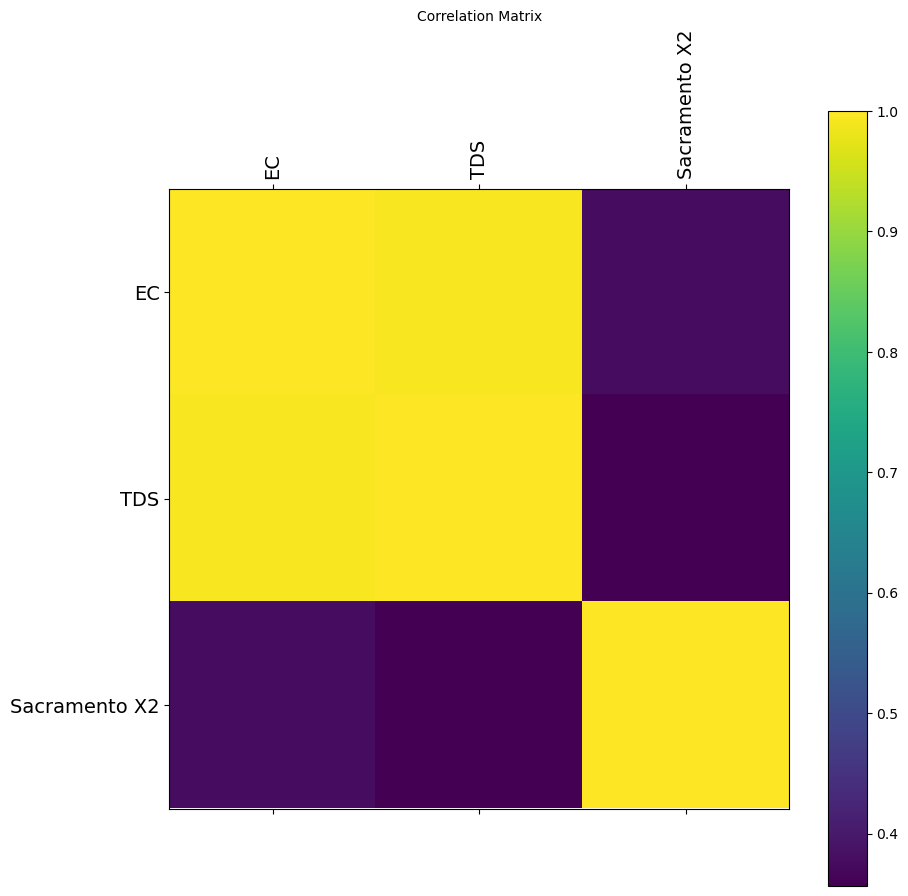

In [6]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(
    ['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(
    ['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=10)
plt.title('Correlation Matrix', fontsize=10)

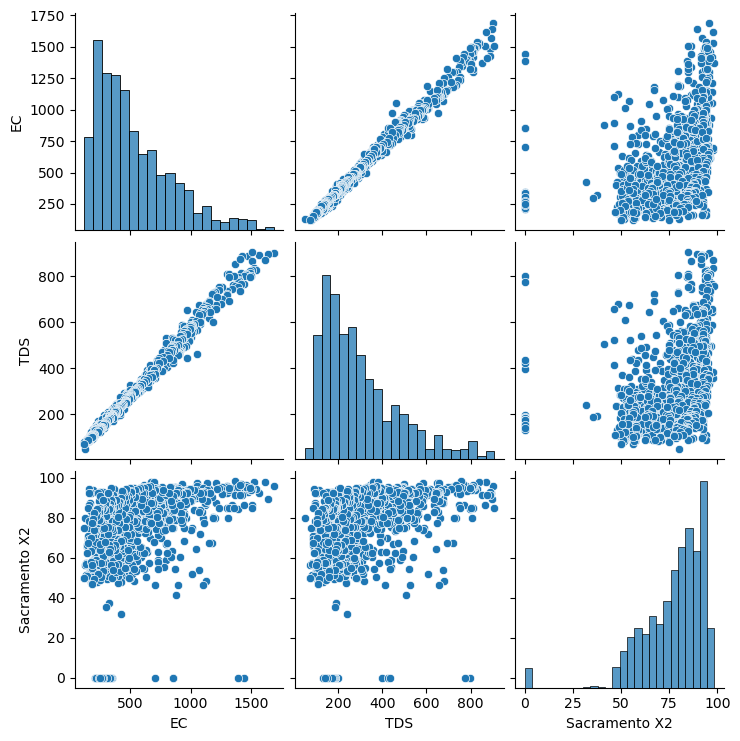

In [7]:
sns.pairplot(df2[['EC',Ion, 'Sacramento X2']])

<AxesSubplot:xlabel='EC', ylabel='TDS'>

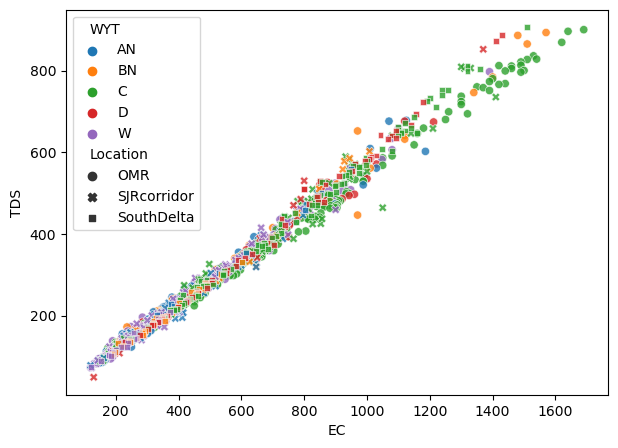

In [9]:
plt.figure(figsize=(7, 5), dpi=100)
sns.scatterplot(x='EC', y=Ion, data=df, hue='WYT', style='Location', alpha=0.8)

<AxesSubplot:xlabel='Location', ylabel='count'>

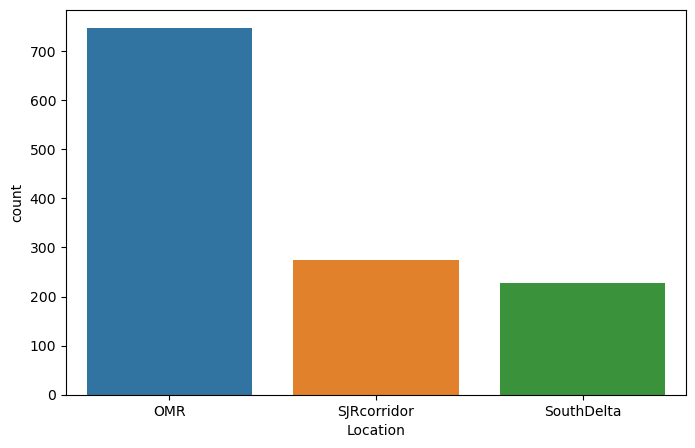

In [10]:
plt.figure(figsize=(8, 5), dpi=100)
sns.countplot(data=df, x='Location')

<AxesSubplot:xlabel='WYT', ylabel='count'>

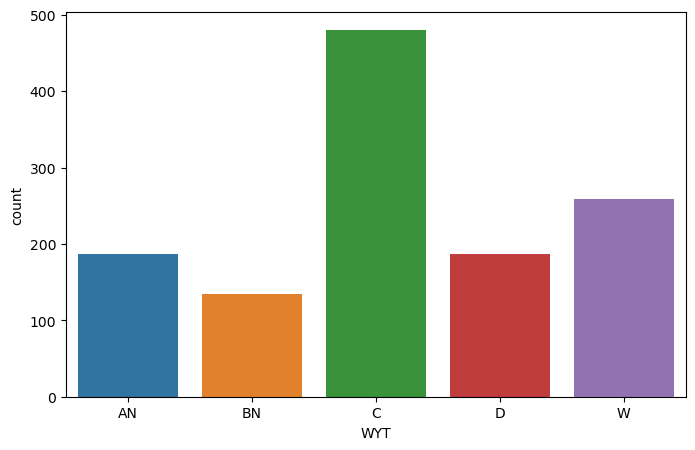

In [11]:
plt.figure(figsize=(8, 5), dpi=100)
sns.countplot(data=df, x='WYT')

<AxesSubplot:xlabel='WYT', ylabel='TDS'>

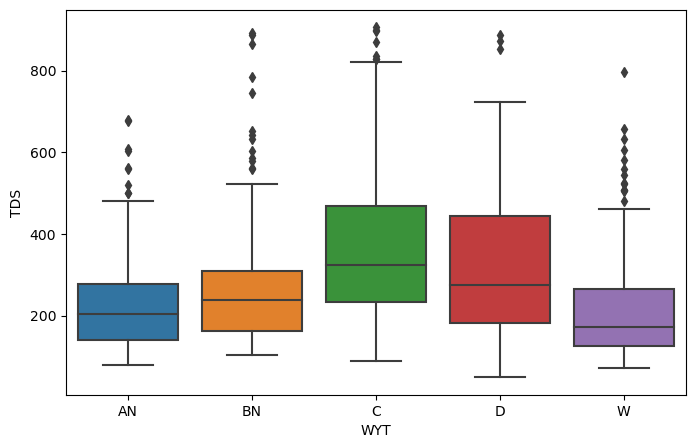

In [12]:
plt.figure(figsize=(8, 5), dpi=100)
sns.boxplot(data=df, y=Ion, x='WYT')

<AxesSubplot:xlabel='WYT', ylabel='EC'>

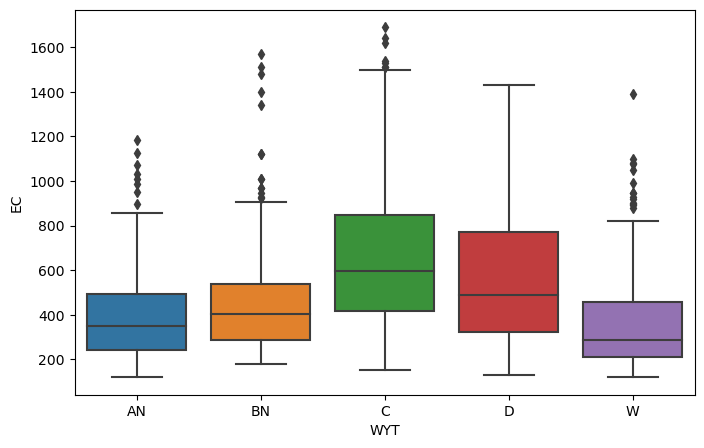

In [13]:
plt.figure(figsize=(8,5),dpi=100)
sns.boxplot(data=df,y='EC', x='WYT')

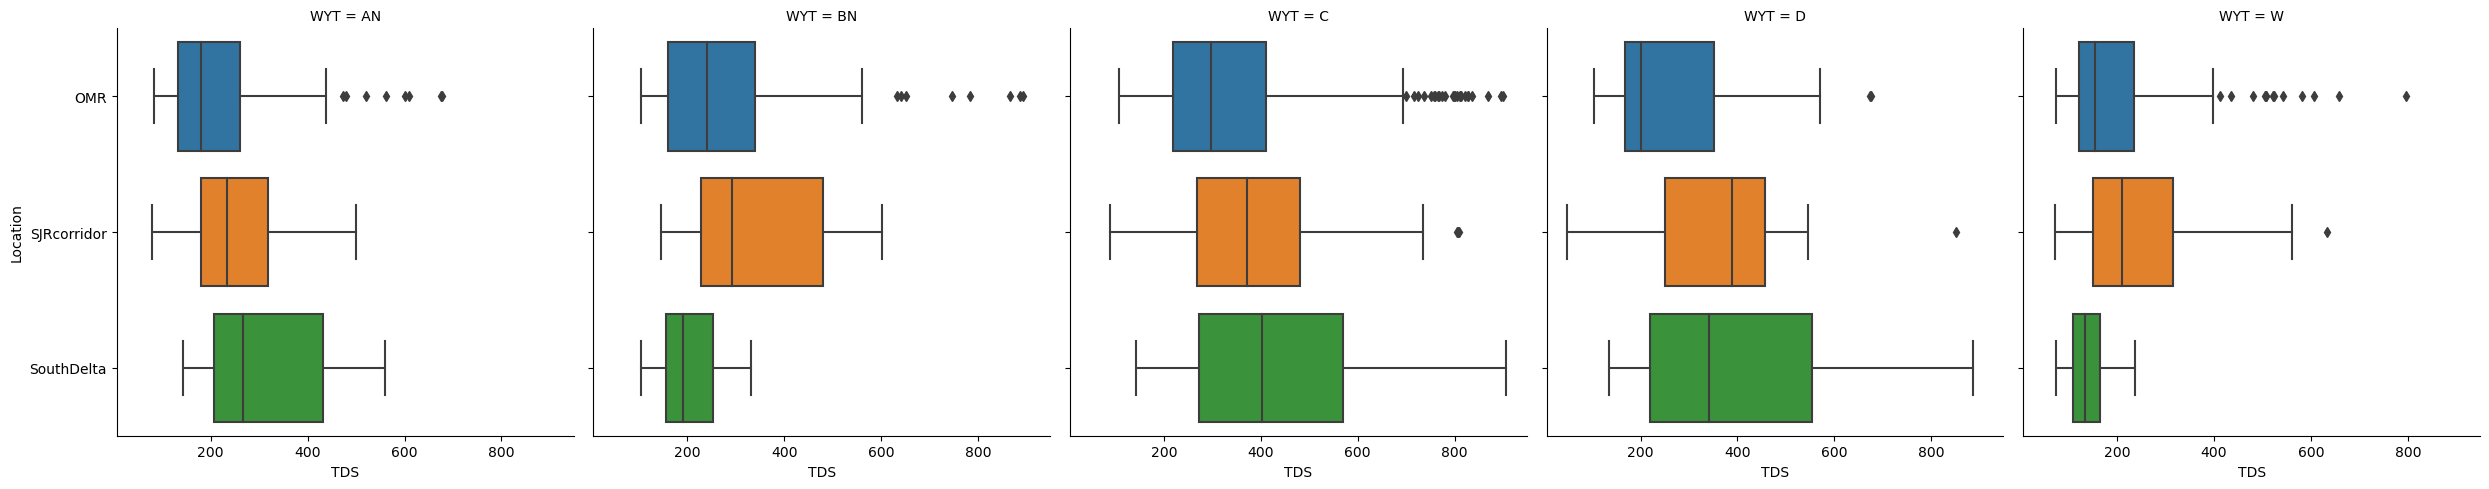

In [14]:
sns.catplot(data=df, x=Ion, y='Location', kind='box', col= 'WYT')

## Splitting the dataset into the Training set and Test set
# &
## Feature Scaling

In [17]:
from sklearn.model_selection import train_test_split
df = df2
X = df.drop(Ion, axis=1)
y = df[Ion]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=92)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range = (0, 1))
# # from sklearn.preprocessing import StandardScaler
# # scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(998, 19)
(998,)
(250, 19)
(250,)


# ML algorithms

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

regressorLinear = LinearRegression()
regressorTree = DecisionTreeRegressor(random_state=0)
regressorRF = RandomForestRegressor(n_estimators=500, random_state=0)
regressorGB = GradientBoostingRegressor()
regressorAB = AdaBoostRegressor()

print(Ion)

regressorLinear.fit(X_train, y_train)
y_pred_test = regressorLinear.predict(X_test)
y_pred_train = regressorLinear.predict(X_train)
y_pred_LR = regressorLinear.predict(X)
y_pred_test_LR = regressorLinear.predict(X_test)
print("LinearRegression:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))

print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_LR), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_LR), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_LR), ndigits=2))

print("        ")


regressorTree.fit(X_train, y_train)
y_pred_test = regressorTree.predict(X_test)
y_pred_train = regressorTree.predict(X_train)
y_pred_RT = regressorTree.predict(X)
y_pred_test_RT = regressorTree.predict(X_test)
print("DecisionTreeRegressor:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_RT), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_RT), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_RT), ndigits=2))
print("        ")

regressorRF.fit(X_train, y_train)
y_pred_test = regressorRF.predict(X_test)
y_pred_train = regressorRF.predict(X_train)
y_pred_RF = regressorRF.predict(X)
y_pred_test_RF = regressorRF.predict(X_test)
print("Random Forest:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_RF), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_RF), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_RF), ndigits=2))
print("        ")

regressorGB.fit(X_train, y_train)
y_pred_test = regressorGB.predict(X_test)
y_pred_train = regressorGB.predict(X_train)
y_pred_GB = regressorGB.predict(X)
y_pred_test_GB = regressorGB.predict(X_test)
print("GradientBoosting:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_GB), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_GB), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_GB), ndigits=2))
print("        ")

regressorAB.fit(X_train, y_train)
y_pred_test = regressorAB.predict(X_test)
y_pred_train = regressorAB.predict(X_train)
y_pred_AB = regressorAB.predict(X)
y_pred_test_AB = regressorAB.predict(X_test)
print("Adaboost:")
print("        ", "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print("        ", "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2), "  MAE =", round(
    mean_absolute_error(y_test, y_pred_test), ndigits=2), "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))
print("        ", "All    ", "R2 =", round(r2_score(y, y_pred_AB), ndigits=2), "  MAE =", round(
    mean_absolute_error(y, y_pred_AB), ndigits=2), "  MSE =", round(mean_squared_error(y, y_pred_AB), ndigits=2))
print("        ")

TDS
LinearRegression:
         Training R2 = 0.99   MAE = 11.8   MSE = 299.17
         Test     R2 = 0.99   MAE = 10.53   MSE = 196.31
         All     R2 = 0.99   MAE = 11.55   MSE = 278.56
        
DecisionTreeRegressor:
         Training R2 = 1.0   MAE = 0.01   MSE = 0.04
         Test     R2 = 0.99   MAE = 11.96   MSE = 342.96
         All     R2 = 1.0   MAE = 2.4   MSE = 68.74
        
Random Forest:
         Training R2 = 1.0   MAE = 3.84   MSE = 39.37
         Test     R2 = 0.99   MAE = 8.57   MSE = 159.72
         All     R2 = 1.0   MAE = 4.78   MSE = 63.48
        
GradientBoosting:
         Training R2 = 1.0   MAE = 7.52   MSE = 122.47
         Test     R2 = 0.99   MAE = 8.87   MSE = 168.14
         All     R2 = 1.0   MAE = 7.79   MSE = 131.62
        
Adaboost:
         Training R2 = 0.98   MAE = 18.12   MSE = 538.61
         Test     R2 = 0.98   MAE = 16.52   MSE = 468.44
         All     R2 = 0.98   MAE = 17.8   MSE = 524.55
        


In [19]:
df['LR'] = y_pred_LR
df['RT'] = y_pred_RT
df['RF'] = y_pred_RF
df['GB'] = y_pred_GB
df['AB'] = y_pred_AB

# ANN

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=86)

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [22]:
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=19, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=20, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=20, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=10, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=5, activation='ELU'))
ann.add(tf.keras.layers.Dense(units=1))
ann.compile(optimizer=keras.optimizers.Adamax(
    learning_rate=0.001), loss="mse", metrics=['accuracy'])
history = ann.fit(X_train, y_train, validation_split=0.33,
                  batch_size=16, epochs=200)

y_pred_test = ann.predict(X_test)
y_pred_train = ann.predict(X_train)


print(Ion, "Training", "R2 =", round(r2_score(y_train, y_pred_train), ndigits=2), "  MAE =", round(mean_absolute_error(
    y_train, y_pred_train), ndigits=2), "  MSE =", round(mean_squared_error(y_train, y_pred_train), ndigits=2))
print(Ion, "Test    ", "R2 =", round(r2_score(y_test, y_pred_test), ndigits=2),  "  MAE =", round(mean_absolute_error(
    y_test, y_pred_test), ndigits=2),  "  MSE =", round(mean_squared_error(y_test, y_pred_test), ndigits=2))

Epoch 1/200
42/42 [==============================] - 1s 6ms/step - loss: 116073.4219 - accuracy: 0.0000e+00 - val_loss: 124960.1562 - val_accuracy: 0.0000e+00
Epoch 2/200
42/42 [==============================] - 0s 2ms/step - loss: 115227.0156 - accuracy: 0.0000e+00 - val_loss: 123899.2578 - val_accuracy: 0.0000e+00
Epoch 3/200
42/42 [==============================] - 0s 2ms/step - loss: 113825.6406 - accuracy: 0.0000e+00 - val_loss: 122134.7656 - val_accuracy: 0.0000e+00
Epoch 4/200
42/42 [==============================] - 0s 2ms/step - loss: 111633.0078 - accuracy: 0.0000e+00 - val_loss: 119400.3125 - val_accuracy: 0.0000e+00
Epoch 5/200
42/42 [==============================] - 0s 2ms/step - loss: 108442.9922 - accuracy: 0.0000e+00 - val_loss: 115481.1406 - val_accuracy: 0.0000e+00
Epoch 6/200
42/42 [==============================] - 0s 2ms/step - loss: 103396.3438 - accuracy: 0.0000e+00 - val_loss: 109050.8516 - val_accuracy: 0.0000e+00
Epoch 7/200
42/42 [===========================

In [23]:
y_pred_ANN = ann.predict(X)
df['ANN'] = y_pred_ANN

39/39 [==============================] - 0s 842us/step
